Show that, when lazy primitives (a 2nd order approximation) is turned on, the high-order accuracy of the 3rd order solver is contaminated in one step.

In [ ]:
from superfv import EulerSolver
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

In [33]:
H0 = 1
rho0 = 1
P0 = 1
gamma = 1.4
T = 1


def velocity_ramp(array_slicer, x, y, z, t):
    _slc = array_slicer
    out = np.empty((len(_slc.idxs), *x.shape))
    out[_slc("rho")] = rho0 / (1 + H0 * t)
    out[_slc("vx")] = (H0 / (1 + H0 * t)) * (x - 0.5)
    out[_slc("vy")] = 0
    out[_slc("vz")] = 0
    out[_slc("P")] = P0 / ((1 + H0 * t) ** gamma)
    return out


solver = EulerSolver(
    ic=partial(velocity_ramp, t=0),
    bcx=("dirichlet", "dirichlet"),
    x_dirichlet=(velocity_ramp, velocity_ramp),
    gamma=gamma,
    lazy_primitives=True,
    nx=16,
    p=2,
    CFL=0.8,
)

In [34]:
def plot_velocity_ramp_one_step(lazy_primitives: bool):
    mode = "transverse"
    _p = 2
    t = 0
    u = solver.arrays["u"]

    n_ghost_cells = -(-_p // 2) + 1
    u_padded = solver.apply_bc(u, n_ghost_cells, t)

    if lazy_primitives:
        w_padded = solver.primitives_from_conservatives(u_padded)
    else:
        w_padded = solver.interpolate_cell_centers(
            u_padded, interpolation_scheme=mode, p=_p
        )
        w_padded = solver.primitives_from_conservatives(w_padded)
        w_padded = solver.interpolate(w_padded, p=_p, stencil_type="uniform-quadrature")

    plt.plot(w_padded[4].flatten() - 1)
    plt.xlabel("$x$ index")
    plt.ylabel("$P$ error")

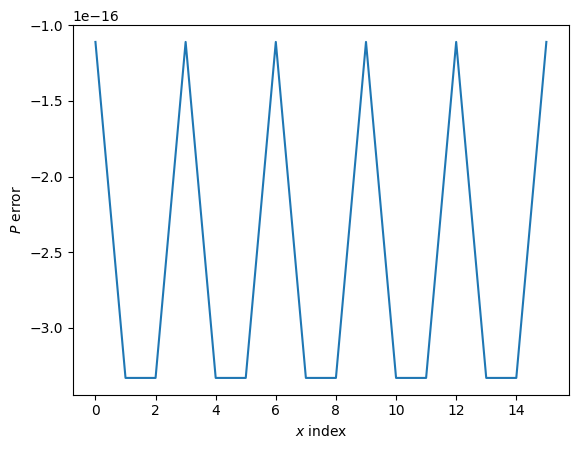

In [35]:
plot_velocity_ramp_one_step(lazy_primitives=False)

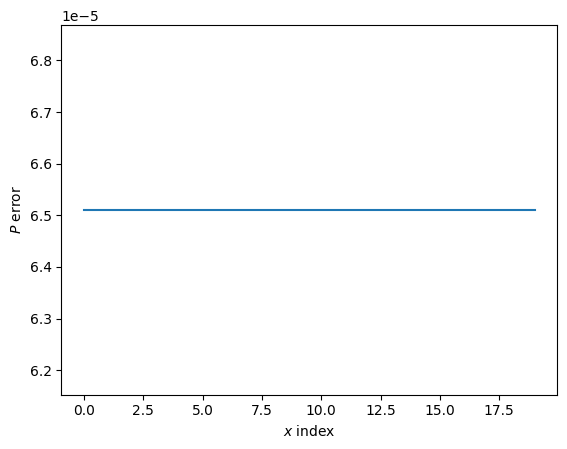

In [36]:
plot_velocity_ramp_one_step(lazy_primitives=True)